In [84]:
from transformers import BertTokenizer, BertModel
from transformers import get_linear_schedule_with_warmup
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from torch.optim import AdamW
import pandas as pd
import numpy as np
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
from sklearn import metrics
import time
import sklearn
import seaborn as sns
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
from transformers import BertForSequenceClassification


In [57]:
import pandas as pd
import numpy as np

data = pd.read_csv(r'/Users/wanqian/pytorch-test/IR/preprocessed.csv', index_col=[0])

data

,Sentiment,text
0,1,good price return
1,1,device work advertise like size
2,0,looks good battery suck phone arrive appeared ...
3,1,like new excellent condition
4,0,battery disappointment take time get use phone...
...,...,...
1217,-1,purchase cprtx return inmediately pray get ste...
1218,-1,pleased packaging phone
1219,1,great phone great phone renew like new wish sm...
1220,-1,wrong charger charge cable send travel phone d...


In [ ]:

df.plot.bar(x='Word',y='Count')

In [58]:
# Split the training and test data into 80/20 split
train_pct = .8
np.random.seed(1)
idx = np.random.permutation(len(data))

X_train = data['text'].values[idx[:int(train_pct*len(data))]]
y_train = data['Sentiment'].values[idx[:int(train_pct*len(data))]]
y_train[y_train==-1] = 0
X_test = data['text'].values[idx[int(train_pct*len(data)):]]
y_test = data['Sentiment'].values[idx[int(train_pct*len(data)):]]
y_test[y_test==-1] = 0

In [59]:
# Prepare the Bert NLP model tokenizer to encode reviews
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

In [60]:
# Define function to encode bert 
def preprocessing_for_bert(data):
    """Perform required preprocessing steps for pretrained BERT.
    @param    data (np.array): Array of texts to be processed.
    @return   input_ids (torch.Tensor): Tensor of token ids to be fed to a model.
    @return   attention_masks (torch.Tensor): Tensor of indices specifying which
                  tokens should be attended to by the model.
    """
    #Initializing empty lists to store outputs 
    input_ids = []
    attention_masks = []
    
    # For each review
    for line in data:
        
        #    (1) Tokenize the sentence
        #    (2) Add the `[CLS]` and `[SEP]` token to the start and end
        #    (3) Truncate/Pad sentence to max length
        #    (4) Map tokens to their IDs
        #    (5) Create attention mask
        #    (6) Return a dictionary of outputs
        
        encoding_data = tokenizer.encode_plus(
                text=line,                     # reviewer to encode
                add_special_tokens=True,       # adds '[CLS]' and '[SEP]' to encoding 
                padding='max_length',          # pad the tweets with 0s to fit max length
                max_length = MAX_LEN,          # assign max length
                truncation=True,               # truncate tweets longer than max length -> reduces the resource overhead of logging the deletions, as well as the number of locks acquired.
                return_tensors="pt",           # return tensor as pytorch tensor
                return_attention_mask=True     # return the attention mask
                )

        # add the encodings to the list
        input_ids.append(encoding_data.get('input_ids'))
        attention_masks.append(encoding_data.get('attention_mask'))
    
    # Change the lists to tensors
    input_ids = torch.concat(input_ids)
    attention_masks = torch.concat(attention_masks)
    
    return input_ids, attention_masks

In [61]:
encoded = [tokenizer.encode(sent, add_special_tokens=True) for sent in data['text'].values]
MAX_LEN = max([len(sent) for sent in encoded])
print('Max length: ', MAX_LEN)

Max length:  265


In [62]:
print (encoded[1])

[101, 5080, 2147, 4748, 16874, 5562, 2066, 2946, 102]


In [63]:
# Encode the train and test data for Bert
X_train_inputs, X_train_masks = preprocessing_for_bert(X_train)
X_test_inputs, X_test_masks = preprocessing_for_bert(X_test)
# Get the train and test labels
y_train_labels = torch.tensor(y_train)
y_test_labels = torch.tensor(y_test)

print(X_train_inputs.shape, X_train_masks.shape, y_train_labels.shape)
print(X_test_inputs.shape, X_test_masks.shape, y_test_labels.shape)

torch.Size([977, 265]) torch.Size([977, 265]) torch.Size([977])
torch.Size([245, 265]) torch.Size([245, 265]) torch.Size([245])


In [64]:
# Set batch size to 16. recommended 16 or 32 depending on GPU size 
batch_size = 16

# Randomize the train data and define dataloader for model training 
train_data = TensorDataset(X_train_inputs, X_train_masks, y_train_labels)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

# Randomize the test data and define dataloader for model testing
test_data = TensorDataset(X_test_inputs, X_test_masks, y_test_labels)
test_sampler = SequentialSampler(test_data)
test_dataloader = DataLoader(test_data, sampler=test_sampler, batch_size=batch_size)

In [65]:
# Define the Bert NLP Classifier
class BertClassifier(nn.Module):
    def __init__(self, freeze=False):
        super(BertClassifier, self).__init__()
        
    
        ##@param    bert: a BertModel object
        ##@param    classifier: a torch.nn.Module classifier
        ##@param    freeze_bert (bool): Set `False` to fine-tune the BERT model
        

        # Define the neurons for the final layer
        input_layer = 768
        hidden_layer = 50
        output_layer = 2

        # Use the pretrained Bert model for first section of NN
        self.bert = BertModel.from_pretrained('bert-base-uncased')

        # Define a final layer to attach to the Bert model for custom classification
        self.classifier = nn.Sequential(
            nn.Linear(input_layer, hidden_layer), 
            nn.ReLU(), 
            nn.Linear(hidden_layer, output_layer))

        # Freeze the model from updating
        if freeze:
            for param in self.bert.parameters():
                param.requires_grad = False
        
    # Return classification from Bert model 
    def forward(self, input_ids, attention_mask):
        outputs = self.bert(input_ids, attention_mask)
        h_cls = outputs[0][:, 0, :]
        logits = self.classifier(h_cls)

        return logits

In [66]:
# Set random seed for repeatability
torch.manual_seed(1)
torch.cuda.manual_seed_all(1)
np.random.seed(1)

#check pytorch has access to MPS (Apple's GPU)
print(f"Is MPS available? {torch.backends.mps.is_available()}")
print(f"Is MPS (Metal Performance Shader) built? {torch.backends.mps.is_built()}")

Is MPS available? True
Is MPS (Metal Performance Shader) built? True


In [67]:
# Check if GPU is available and assign device 
if torch.backends.mps.is_available():       
    device = "mps"
else:
    device = "cpu"

print(f"Using Device: {device}")

Using Device: mps


In [68]:
# Initialize Bert Classifier
model = BertClassifier(freeze=False)

# Send model to device (GPU if available)
model.to(device)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


BertClassifier(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=Tru

In [14]:
# Define model hyperparameters
epochs = 5
steps = len(train_dataloader) * epochs
learning_rate = 5e-5
epsilon = 1e-8

# Define Adam optimizer
optimizer = AdamW(model.parameters(), lr=learning_rate, eps=epsilon)

# Define scheduler for training the optimizer 
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=steps)

# Define cross entropy loss function 
loss_function = nn.CrossEntropyLoss()

In [17]:
true_labels = []
predicted_labels = []
n = 1 

In [18]:
# For the number of epochs
for e in range(epochs):
    
    
    print('Epoch', n, 'is starting...')
    
    start_time = time.time()
    
    # Assign model to train
    model.train()

    # Intialize loss to zero
    train_loss = 0
    
    # For each batch
    for batch in train_dataloader:
        # Get batch inputs, masks and labels 
        batch_inputs, batch_masks, batch_labels = batch
        
        # Send variables to device (GPU if available)
        batch_inputs = batch_inputs.to(device)
        batch_masks = batch_masks.to(device)
        batch_labels = batch_labels.to(device)

        # Reset the model gradient
        model.zero_grad()

        # Get classification of encoded values
        logits = model(batch_inputs, batch_masks)
        
        # Calculate loss based on predictions and known values
        loss = loss_function(logits, batch_labels)
        
        # Add loss to the running total
        train_loss += loss.item()
        
        # Update the model weights based on the loss 
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()
        scheduler.step()

    # Calculate the average loss over batch
    train_loss /= len(train_dataloader)
    
    # Assign the model to evaluate    
    model.eval()

    # Initialize losses
    test_loss = 0
    test_acc = 0

    for batch in test_dataloader:
        # Get encoding inputs, masks and labels
        batch_inputs, batch_masks, batch_labels = batch
        
        # Send variables to device (GPU if available)
        batch_inputs = batch_inputs.to(device)
        batch_masks = batch_masks.to(device)
        batch_labels = batch_labels.to(device)

        # Predict the input values without updating the model 
        with torch.no_grad():
            logits = model(batch_inputs, batch_masks)

        # Calculate the loss
        loss = loss_function(logits, batch_labels)
        test_loss += loss.item()

        # Convert predictions to 0 and 1
        preds = torch.argmax(logits, dim=1).flatten()
        
        # Append true labels and predicted labels to the lists
        true_labels += batch_labels.cpu().numpy().tolist()
        predicted_labels += preds.cpu().numpy().tolist()

        # Calculate accuracy of model on test data 
        accuracy = (preds == batch_labels).cpu().numpy().mean() * 100
        test_acc += accuracy
        

    # Calculate average loss and accuracy per each batch
    test_loss /= len(test_dataloader)
    test_acc /= len(test_dataloader)
    
    # End timer for epoch
    end_time = time.time()
    n += 1

    # Print epoch information 
    print('Epoch: %d  |  Train Loss: %1.5f  |  Test Loss: %1.5f  |  Test Accuracy: %1.2f  |  Time taken: %d seconds'%(e+1, train_loss, test_loss, test_acc, end_time-start_time))

Epoch 1 is starting...
Epoch: 1  |  Train Loss: 0.49276  |  Test Loss: 0.47586  |  Test Accuracy: 83.52  |  Time taken: 666 seconds
Epoch 2 is starting...
Epoch: 2  |  Train Loss: 0.32043  |  Test Loss: 0.38284  |  Test Accuracy: 85.47  |  Time taken: 605 seconds
Epoch 3 is starting...
Epoch: 3  |  Train Loss: 0.18731  |  Test Loss: 0.41837  |  Test Accuracy: 86.64  |  Time taken: 652 seconds
Epoch 4 is starting...
Epoch: 4  |  Train Loss: 0.08052  |  Test Loss: 0.60990  |  Test Accuracy: 84.30  |  Time taken: 719 seconds
Epoch 5 is starting...
Epoch: 5  |  Train Loss: 0.04742  |  Test Loss: 0.60566  |  Test Accuracy: 85.47  |  Time taken: 708 seconds


In [78]:
def save_model(model, tokenizer, model_path):
    """
    Saves the trained model and tokenizer to the given path.

    Args:
        model (:obj:`BertForSequenceClassification`): The trained BERT model.
        tokenizer (:obj:`BertTokenizer`): The BERT tokenizer.
        model_path (:obj:`str`): The path where the model and tokenizer will be saved.
    """
    # Save the model state dict
    torch.save(model.state_dict(), model_path)
    
    # Save the tokenizer
    tokenizer.save_pretrained(model_path)


In [19]:
report = sklearn.metrics.classification_report(true_labels, predicted_labels)
print(report)


              precision    recall  f1-score   support

           0       0.84      0.92      0.88       695
           1       0.88      0.77      0.82       530

    accuracy                           0.85      1225
   macro avg       0.86      0.84      0.85      1225
weighted avg       0.85      0.85      0.85      1225



In [69]:
# Save the pre-trained weights
torch.save(model.state_dict(), "pretrained_weights_BERT.pth")


In [70]:
cm = metrics.confusion_matrix(true_labels, predicted_labels)
print(cm)

auc = metrics.roc_auc_score(true_labels, predicted_labels)
print(auc)

[[637  58]
 [122 408]]
0.8431790416723226


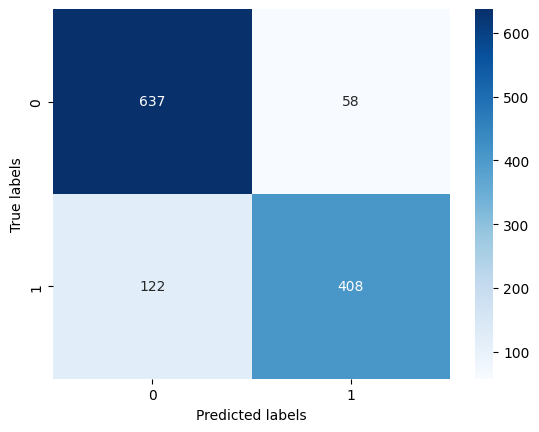

In [71]:
# Plot the confusion matrix
sns.heatmap(cm, annot=True, cmap='Blues', fmt='g')

# Set plot labels
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.show()

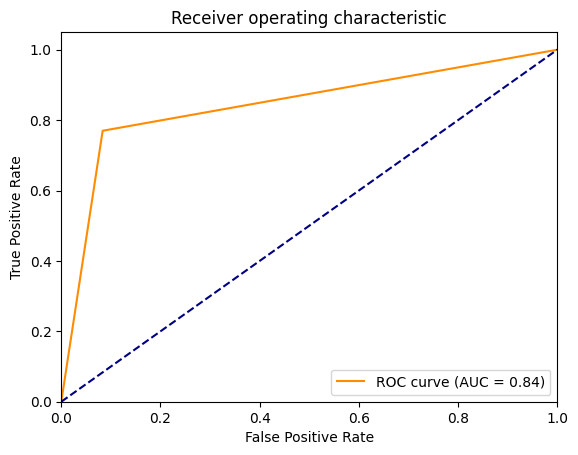

In [72]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

# Assuming your true_labels and predicted_labels are binary
fpr, tpr, thresholds = roc_curve(true_labels, predicted_labels)
roc_auc = auc(fpr, tpr)

# Plotting the ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', label='ROC curve (AUC = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()


In [73]:
df = pd.read_csv(r'/Users/wanqian/pytorch-test/IR/preprocessed_all.csv', index_col=[0])

df

,rating,productAsin,reviewDate,size,color,service_provider,product_grade,review_link,image_links,text
0,4,B088NQXD8T,"Reviewed in the United States on March 29, 2023",64GB,Red,Unlocked,Renewed,https://www.amazon.com//gp/customer-reviews/R3...,[],may bad luck ok iphone receive 910 cosmeticall...
1,4,B088NQXD8T,"Reviewed in the United States on March 16, 2023",128GB,Red,Unlocked,Renewed Premium,https://www.amazon.com//gp/customer-reviews/R1...,[],renew premium excellent condition 91 battery p...
2,4,B088NQXD8T,"Reviewed in the United States on March 20, 2023",128GB,Red,Unlocked,Renewed,https://www.amazon.com//gp/customer-reviews/R1...,[],good phone appear clean almost call brand new ...
3,4,B088NQXD8T,"Reviewed in the United States on March 20, 2023",256GB,Red,AT&T,Renewed,https://www.amazon.com//gp/customer-reviews/R1...,['https://m.media-amazon.com/images/W/IMAGEREN...,phone arrive early look nearly new complaint w...
4,4,B088NQXD8T,"Reviewed in the United States on March 1, 2023",128GB,White,Unlocked,Renewed,https://www.amazon.com//gp/customer-reviews/R2...,['https://m.media-amazon.com/images/I/51YzAIX5...,would consider excellent condition really good...
...,...,...,...,...,...,...,...,...,...,...
11540,1,B07P6Y8L3F,"Reviewed in the United States on January 26, 2021",64GB,Black,Unlocked,Renewed,https://www.amazon.com//gp/customer-reviews/R3...,[],iphone xr work properly new iphone xr flicker ...
11541,1,B07P6Y8L3F,"Reviewed in the United States on December 2, 2021",64GB,Black,Unlocked,Renewed,https://www.amazon.com//gp/customer-reviews/R3...,[],battery life last long battery life last long ...
11542,1,B07P6Y8L3F,"Reviewed in the United States on July 6, 2021",64GB,Black,Unlocked,Renewed,https://www.amazon.com//gp/customer-reviews/R1...,[],nan purchase phone may 21st 2021 line appear s...
11543,1,B07P6Y8L3F,"Reviewed in the United States on December 27, ...",64GB,Black,Unlocked,Renewed,https://www.amazon.com//gp/customer-reviews/RB...,[],happy battery life shipping time good thing pr...


In [74]:
# Encode processed tweets for Bert NLP model
review_inputs, review_masks = preprocessing_for_bert(df['text'].values)

In [75]:
# Put review data in PyTorch dataloader for processing 
review_data = TensorDataset(review_inputs, review_masks)
review_sampler = RandomSampler(review_data)
review_dataloader = DataLoader(review_data, sampler=review_sampler, batch_size=batch_size)

In [76]:
# Assign model to evaluate 
model.eval()

predictions = []

In [77]:
for batch in review_dataloader:
    # Get encoded inputs and masks 
    batch_inputs, batch_masks = batch

    # Send variables to device (GPU if available)
    batch_inputs = batch_inputs.to(device)
    batch_masks = batch_masks.to(device)

    # Predict classes with Bert for given inputs 
    with torch.no_grad():
        logits = model(batch_inputs, batch_masks)

    # Convert predictions to 0s and 1s
    preds = torch.argmax(logits, dim=1)
    predictions.append(preds)

In [79]:
# Combine all batch predictions
predictions = torch.cat(predictions).cpu().numpy()
    
# Add predictions to stock dataframe
df['Sentiment'] = predictions
    
# save predictions as new csv
df.to_csv(r'/Users/wanqian/pytorch-test/IR/preprocessed_labelled.csv', index=False)
    
# Show stock names as they are completed 
print('completed sentiment analysis')

completed sentiment analysis


In [80]:
df


,rating,productAsin,reviewDate,size,color,service_provider,product_grade,review_link,image_links,text,Sentiment
0,4,B088NQXD8T,"Reviewed in the United States on March 29, 2023",64GB,Red,Unlocked,Renewed,https://www.amazon.com//gp/customer-reviews/R3...,[],may bad luck ok iphone receive 910 cosmeticall...,1
1,4,B088NQXD8T,"Reviewed in the United States on March 16, 2023",128GB,Red,Unlocked,Renewed Premium,https://www.amazon.com//gp/customer-reviews/R1...,[],renew premium excellent condition 91 battery p...,1
2,4,B088NQXD8T,"Reviewed in the United States on March 20, 2023",128GB,Red,Unlocked,Renewed,https://www.amazon.com//gp/customer-reviews/R1...,[],good phone appear clean almost call brand new ...,1
3,4,B088NQXD8T,"Reviewed in the United States on March 20, 2023",256GB,Red,AT&T,Renewed,https://www.amazon.com//gp/customer-reviews/R1...,['https://m.media-amazon.com/images/W/IMAGEREN...,phone arrive early look nearly new complaint w...,1
4,4,B088NQXD8T,"Reviewed in the United States on March 1, 2023",128GB,White,Unlocked,Renewed,https://www.amazon.com//gp/customer-reviews/R2...,['https://m.media-amazon.com/images/I/51YzAIX5...,would consider excellent condition really good...,1
...,...,...,...,...,...,...,...,...,...,...,...
11540,1,B07P6Y8L3F,"Reviewed in the United States on January 26, 2021",64GB,Black,Unlocked,Renewed,https://www.amazon.com//gp/customer-reviews/R3...,[],iphone xr work properly new iphone xr flicker ...,1
11541,1,B07P6Y8L3F,"Reviewed in the United States on December 2, 2021",64GB,Black,Unlocked,Renewed,https://www.amazon.com//gp/customer-reviews/R3...,[],battery life last long battery life last long ...,1
11542,1,B07P6Y8L3F,"Reviewed in the United States on July 6, 2021",64GB,Black,Unlocked,Renewed,https://www.amazon.com//gp/customer-reviews/R1...,[],nan purchase phone may 21st 2021 line appear s...,1
11543,1,B07P6Y8L3F,"Reviewed in the United States on December 27, ...",64GB,Black,Unlocked,Renewed,https://www.amazon.com//gp/customer-reviews/RB...,[],happy battery life shipping time good thing pr...,1


In [85]:
from transformers import BertForSequenceClassification, BertTokenizer
import torch

# Load the pre-trained tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

# Load the pre-trained BERT model for sequence classification
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=2)

# Define the text that you want to analyze
text = "This is a positive review!"

# Tokenize the text
input_ids = torch.tensor(tokenizer.encode(text, add_special_tokens=True)).unsqueeze(0)

# Run the text through the BERT model and get the prediction
outputs = model(input_ids)
prediction = torch.argmax(outputs[0], dim=1)

# Print the prediction (0 for negative sentiment, 1 for positive sentiment)
print(prediction.item())


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

1
